<a href="https://colab.research.google.com/github/appersaravanan/AI_Assignment3/blob/master/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import UpSampling2D,Input,BatchNormalization,Conv2D,Activation,Dropout,LeakyReLU,Flatten,Dense,Conv2DTranspose,Reshape

from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam


import matplotlib.pyplot as plt
from random import randint
from keras.datasets import mnist
from tensorflow.data import Dataset
import time,os

from IPython import display




##Load data from mnist

                                                                    

## Input is defined based on the mnist deminsion

In [18]:
#input shape. cifar images are 32*32 and with RGB color as 3
input_shape=(28,28,1)



#Encoder part

In [19]:


def def_discriminator():
  x = Sequential();
  x.add(Conv2D(filters=32, kernel_size=(5, 5),  strides=(2,2) ,padding='same',input_shape=input_shape))
  x.add(LeakyReLU(0.2))
  x.add(Dropout(0.4))

  x.add(Conv2D(filters=64, kernel_size=(5, 5),  strides=(2,2), padding='same'))
  x.add(LeakyReLU(0.2))
  x.add(Dropout(0.4))

  x.add(Conv2D(filters=128, kernel_size=(5, 5),  strides=(2,2), padding='same'))
  x.add(LeakyReLU(0.2))
  x.add(Dropout(0.4))

  x.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(2,2), padding='same'))
  x.add(LeakyReLU(0.2))
  x.add(Dropout(0.4))
  x.add(Flatten())
  x.add(Dense(1,activation='sigmoid'))
  img= Input(shape=input_shape)
  validity=x(img)
  return Model(img,validity)




In [20]:
dim=7
depth=192

def def_generator ():
  g= Sequential()

  g.add( Dense(dim*dim*depth,input_shape=(100,) )) 
  g.add( BatchNormalization())
  g.add( Activation('relu'))

  g.add( Reshape((dim, dim, depth)))
  g.add( Dropout(0.4))
  g.add(UpSampling2D((2, 2)))

  g.add( Conv2DTranspose(filters=96, kernel_size=(5, 5), strides=1, padding='same') )
  g.add(BatchNormalization())
  g.add( Activation('relu'))
  g.add( UpSampling2D((2, 2)))

  g.add( Conv2DTranspose(filters=48, kernel_size=(5, 5), strides=1, padding='same'))
  g.add(BatchNormalization())

  g.add( Activation('relu'))


  g.add(Conv2DTranspose(filters=24, kernel_size=(5, 5), strides=1, padding='same'))
  g.add( BatchNormalization())
  g.add( Activation('relu'))


  g.add( Conv2DTranspose(filters=1, kernel_size=(5, 5), strides=1, padding='same')) 
  g.add(Activation('tanh'))
  #generator.compile (loss='binary_crossentropy',optimizer=RMSprop(lr=0.0001, decay=3e-8), metrics=['accuracy'] )

  g.summary()
  noise=Input(shape=(100,))
  img =g(noise)

  return Model(noise,img);


In [21]:
batch_size=32
(x_train, _), (_, _) = mnist.load_data()
 
x_train = (x_train.astype(np.float32) - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=3) 

half_batch = int(batch_size / 2)

In [22]:
graph_data=[]
def train(epochs, batch_size=128, save_interval=50):

    for epoch in range(epochs):
        idx = np.random.randint(0, x_train.shape[0], half_batch)
        imgs = x_train[idx] 
        noise = np.random.normal(0, 1, (half_batch, 100))
        gen_imgs = generator.predict(noise)
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
        d_loss = d_loss_real +  d_loss_fake
        noise = np.random.normal(0, 1, (batch_size, 100)) 
        valid_y = np.array([1] * batch_size) #Creates an array of all ones of size=batch size
        g_loss = combined.train_on_batch(noise, valid_y)
        graph_data.append((d_loss[0], g_loss))
        # If at save interval => save generated image samples
        if epoch % save_interval == 0 or (epoch == epochs or  epoch == epochs-1) :
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            save_imgs(epoch)


image_array=[]
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5
    image_array.append(gen_imgs)
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    
    
    plt.show()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 9408)              950208    
_________________________________________________________________
batch_normalization (BatchNo (None, 9408)              37632     
_________________________________________________________________
activation (Activation)      (None, 9408)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 192)         0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 7, 7, 192)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 192)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 96)       

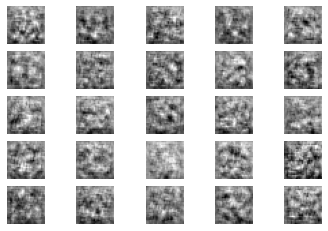

1000 [D loss: 0.571235, acc.: 75.00%] [G loss: 0.831950]


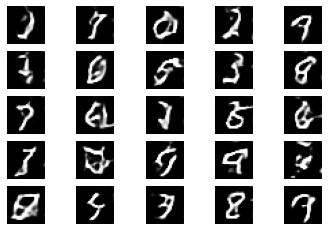

2000 [D loss: 0.686977, acc.: 50.00%] [G loss: 0.775253]


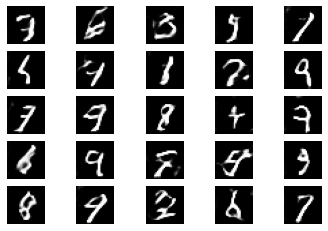

3000 [D loss: 0.773286, acc.: 31.25%] [G loss: 0.786215]


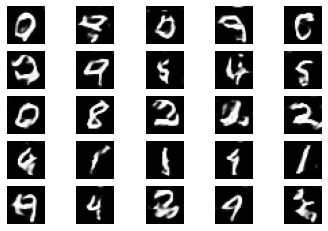

4000 [D loss: 0.582162, acc.: 75.00%] [G loss: 0.945874]


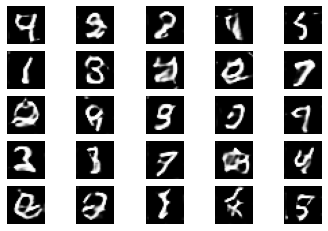

4999 [D loss: 0.695677, acc.: 50.00%] [G loss: 0.803741]


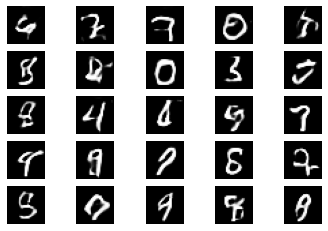

In [23]:
discriminator = def_discriminator()
optimizer = Adam(0.001, 0.5) 
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])


generator = def_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

z = Input(shape=(100,))  
img = generator(z)

discriminator.trainable = False  

valid = discriminator(img)  #Validity check on the generated image



combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)


train(epochs=5000, batch_size=32, save_interval=1000)

In [24]:

print( os.listdir() )
print(os.getcwd())
from google.colab import files
files.download( "gan_4999.png" ) 



['.config', 'sample_data']
/content


FileNotFoundError: ignored

In [ ]:
losses = np.array(graph_data)

fig, ax = plt.subplots()
plt.plot(losses.T[0], label='Discriminator')


plt.title("Training Losses")
plt.legend()


fig, ax = plt.subplots()


plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

In [ ]:

def train_step(images):
    noise = np.random.randn(100, 100).astype("float32")

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)
      #print(generated_images)
      real_output = dis_model(images, training=True)
      #print(real_output)
      fake_output = dis_model(generated_images, training=True)
      #print(fake_output)
      gen_loss = generator_loss(fake_output)
      # print(gen_loss)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, dis_model.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, dis_model.trainable_variables))
    #print(gen_loss)
    print("gen loss: ", np.mean(gen_loss))
    print("dis loss: " ,np.mean(disc_loss))


In [ ]:
def train(ds,epochs):
  for i in range(epochs):
    for images in ds:
      # images= tf.cast(images,tf.dtypes.float32)
      train_step(images)
train(x_train_ds,1)

In [ ]:
plt.imshow(tf.reshape(generator(np.random.randn(1,100)),(28,28)),cmap="gray")